In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
import matplotlib.ticker as ticker
from model_tools import woe_line

from scipy.special import logit

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('df_seminar_logreg_hw.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194366 entries, 0 to 194365
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   application_rk                194366 non-null  int64  
 1   crm_income_dt                 194366 non-null  object 
 2   request_amt                   54418 non-null   float64
 3   bki_flg                       194366 non-null  int64  
 4   no_due_and_short_history_flg  159377 non-null  float64
 5   outstanding_rate              126363 non-null  float64
 6   num_active_credits            159377 non-null  float64
 7   num_status_no_due             159377 non-null  float64
 8   balance_sum                   159377 non-null  float64
 9   due_chance                    159377 non-null  float64
 10  mfo_flg                       159377 non-null  float64
 11  num_fresh_mfo                 159377 non-null  float64
 12  num_month_to_due              159377 non-nul

In [4]:
# техническое поле - месяц прихода заявки в систему
df['month_dt'] = df['crm_income_dt'].astype('datetime64[M]')

In [5]:
# Кумулятивная доля выборки по месяцам

np.round(df.groupby(['month_dt'])['month_dt'].count().cumsum() / df.shape[0], 2)

month_dt
2018-01-01    0.03
2018-02-01    0.06
2018-03-01    0.08
2018-04-01    0.10
2018-05-01    0.11
2018-06-01    0.14
2018-07-01    0.17
2018-08-01    0.21
2018-09-01    0.25
2018-10-01    0.29
2018-11-01    0.34
2018-12-01    0.39
2019-01-01    0.43
2019-02-01    0.48
2019-03-01    0.54
2019-04-01    0.60
2019-05-01    0.64
2019-06-01    0.68
2019-07-01    0.73
2019-08-01    0.78
2019-09-01    0.83
2019-10-01    0.89
2019-11-01    0.95
2019-12-01    1.00
Name: month_dt, dtype: float64

In [6]:
test_mask = (df.month_dt >= '2019-07-01') & (df.month_dt <= '2019-12-01')
validation_mask = (df.month_dt >= '2019-05-01') & (df.month_dt <= '2019-06-01')

In [7]:
df['sample_part'] = 'Train'
df.loc[validation_mask, 'sample_part'] = 'Validation'
df.loc[test_mask, 'sample_part'] = 'Test'

df['sample_part'].value_counts()

Train         116151
Test           61299
Validation     16916
Name: sample_part, dtype: int64

In [8]:
df_train = df[df['sample_part'] == 'Train']
df_val = df[df['sample_part'] == 'Validation']
df_test = df[df['sample_part'] == 'Test']

In [9]:
def get_bad_rate_plot(part_of_df, part_name):
    df_bad_rate = pd.DataFrame(part_of_df.groupby(['month_dt'])['d4p12'].sum())
    df_bad_rate['count'] = part_of_df.groupby(['month_dt'])['month_dt'].count()
    df_bad_rate['bad_rate'] = df_bad_rate['d4p12'] / df_bad_rate['count']
    df_bad_rate['month'] = np.linspace(1, df_bad_rate.shape[0], df_bad_rate.shape[0])

    fig, ax = plt.subplots()
    ax.bar(df_bad_rate['month'], df_bad_rate['bad_rate'], label = 'part_name')

    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))  # интервал написания значений оси OX
    ax.set_xlabel('month')
    ax.set_ylabel('bad_rate')
    ax.legend()

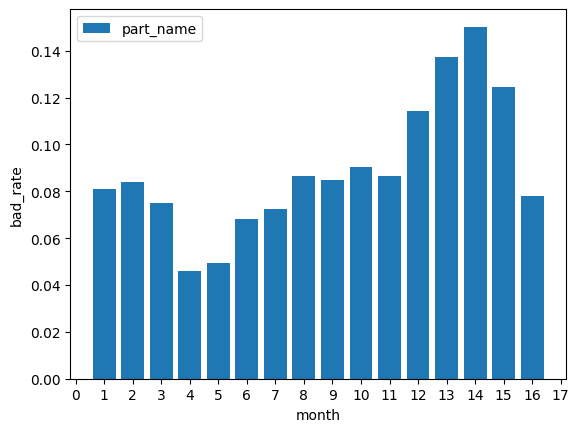

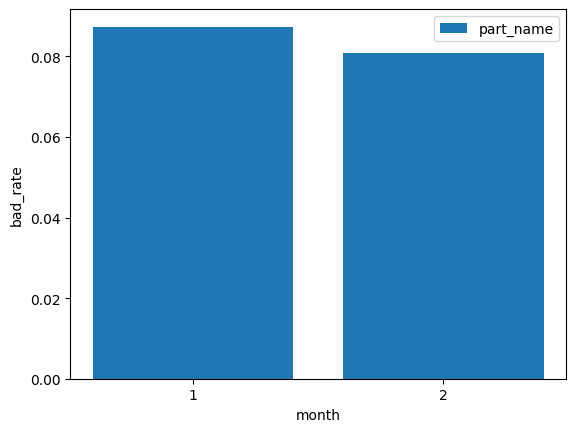

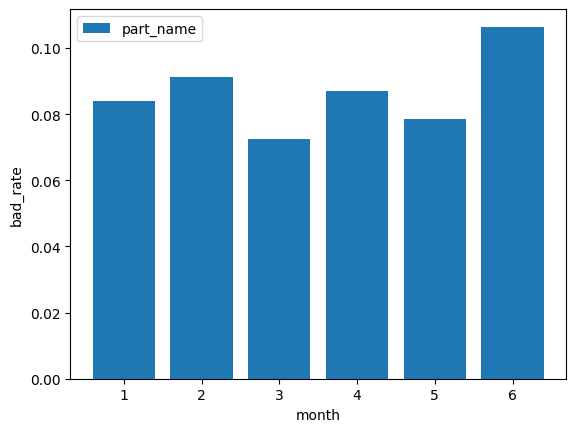

In [10]:
get_bad_rate_plot(df_train, 'Train')
get_bad_rate_plot(df_val, 'Validation')
get_bad_rate_plot(df_test, 'Test')

# Построение модели

**Основное задание**

**Постройте собственную модель логистической регресии, с помощью рассмотренных на семинаре методов, используя любые признаки из датасета.**

* Критерии успешного выполнения
 - Проведены Univariate и Multivariate анализы
 - В модель входят минимум 3 новых признака
 - `ROC AUC` модели превосходит 0.692 на `Train (Seminar_2)` и 0.674 на `Test`
 - Умение интерпретировать свою модель (рассказать про самые сильные признаки, их влияние на целевую переменную)
 
Особенно приветствуются эксперементы с преобразованиями признаков / создание новых!

<font color='red'> Запрещено обучаться на `Test` выборке! </font>

In [11]:
df['num_month'] = df['crm_income_dt'].astype('datetime64[ns]').dt.month

df = pd.get_dummies(df,
                   prefix='num_month',
                   dummy_na=True,
                   columns=['num_month'])

df.head()


,application_rk,crm_income_dt,request_amt,bki_flg,no_due_and_short_history_flg,outstanding_rate,num_active_credits,num_status_no_due,balance_sum,due_chance,...,num_month_4.0,num_month_5.0,num_month_6.0,num_month_7.0,num_month_8.0,num_month_9.0,num_month_10.0,num_month_11.0,num_month_12.0,num_month_nan
0,0,2018-06-22,NaN,1,0.0,0.884391,1.0,31.0,21310.666667,0.325297,...,0,0,1,0,0,0,0,0,0,0
1,1,2019-11-21,NaN,1,0.0,0.997177,1.0,1.0,47579.692308,0.377232,...,0,0,0,0,0,0,0,1,0,0
2,2,2018-03-05,100000.0,1,0.0,NaN,0.0,58.0,76023.428571,0.091311,...,0,0,0,0,0,0,0,0,0,0
3,3,2018-08-08,NaN,1,0.0,0.469932,2.0,231.0,151928.000000,0.034171,...,0,0,0,0,1,0,0,0,0,0
4,4,2019-01-04,NaN,1,0.0,0.129258,1.0,219.0,223517.000000,0.040406,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df['partner1_score'].fillna(df['partner1_score'].median())


0        -3.877620
1        -3.008570
2        -2.656858
3        -2.869361
4        -2.829921
            ...   
194361   -2.855074
194362   -3.459547
194363   -3.430292
194364   -3.353780
194365   -3.177779
Name: partner1_score, Length: 194366, dtype: float64

In [13]:
df['log1p_outstanding_rate'] = np.log1p(df['outstanding_rate'])

In [14]:
# заведем новый признак
df['age_younger_23'] = np.clip(df['age'], 18, 23)

In [15]:
df = pd.get_dummies(df,
                   prefix='marital_status',
                   dummy_na=True,
                   columns=['marital_status_cd'])

df.head()


,application_rk,crm_income_dt,request_amt,bki_flg,no_due_and_short_history_flg,outstanding_rate,num_active_credits,num_status_no_due,balance_sum,due_chance,...,num_month_nan,log1p_outstanding_rate,age_younger_23,marital_status_CIV,marital_status_DIV,marital_status_DLW,marital_status_MAR,marital_status_UNM,marital_status_WID,marital_status_nan
0,0,2018-06-22,NaN,1,0.0,0.884391,1.0,31.0,21310.666667,0.325297,...,0,0.633604,20.0,0,0,0,0,1,0,0
1,1,2019-11-21,NaN,1,0.0,0.997177,1.0,1.0,47579.692308,0.377232,...,0,0.691735,23.0,1,0,0,0,0,0,0
2,2,2018-03-05,100000.0,1,0.0,NaN,0.0,58.0,76023.428571,0.091311,...,0,NaN,23.0,0,0,0,1,0,0,0
3,3,2018-08-08,NaN,1,0.0,0.469932,2.0,231.0,151928.000000,0.034171,...,0,0.385216,23.0,0,0,0,1,0,0,0
4,4,2019-01-04,NaN,1,0.0,0.129258,1.0,219.0,223517.000000,0.040406,...,0,0.121561,23.0,0,0,0,0,1,0,0


In [16]:
# создадим признак женского пола

df['female_flg'] = (df['gender_cd'] == 'F').astype(int)

In [17]:
# импортируем класс WoEFiller

from model_tools import WoEFiller


In [18]:
# создадим объект WoEFiller и используем метод fit - нахождение нулей по WoE для списка фичей
# метод fit возвращает fill_dict, словарь вида name:value

example_filler = WoEFiller()
example_filler.fit(
    X = df.loc[df.sample_part == 'Train'][['telecom1_score']],
    y = df.loc[df.sample_part == 'Train']['d4p12'],
    method='zero_woe'
)

{'telecom1_score': -2.7571730754688675}

In [19]:
df['log_num_status_no_due'] = np.log(df['num_status_no_due'])
df['log_balance_sum'] = np.log(df['balance_sum'])

In [20]:
df.loc[df.sample_part == 'Train'][['log_num_status_no_due', 'log_balance_sum']].corr().round(2)

,log_num_status_no_due,log_balance_sum
log_num_status_no_due,1.00,0.57
log_balance_sum,0.57,1.00


In [21]:
# Используя функционал pandas

pd.crosstab(
    index=df.loc[df.sample_part == 'Train']['education_level_cd'],
    columns=df.loc[df.sample_part == 'Train']['job_type_cd'],
    values=df.loc[df.sample_part == 'Train']['d4p12'],
    aggfunc=np.mean
).round(2)

job_type_cd,БИЗНЕС,БЮДЖЕТ,ПЛОХАЯ,ПРОЧЕЕ,ХОРОШАЯ
education_level_cd,,,,,
-1,0.13,0.07,0.11,0.10,0.07
0,0.15,0.10,0.12,0.13,0.10
1,0.06,0.05,0.07,0.06,0.05
2,0.05,0.04,0.07,0.05,0.04


In [22]:
# функция работает с категориальными и непрерывными переменными
# непрерывные предварительно разбиваются на заданное число бакетов
# отрисовывается количество наблюдейний в каждом бакете

from model_tools import crosstab

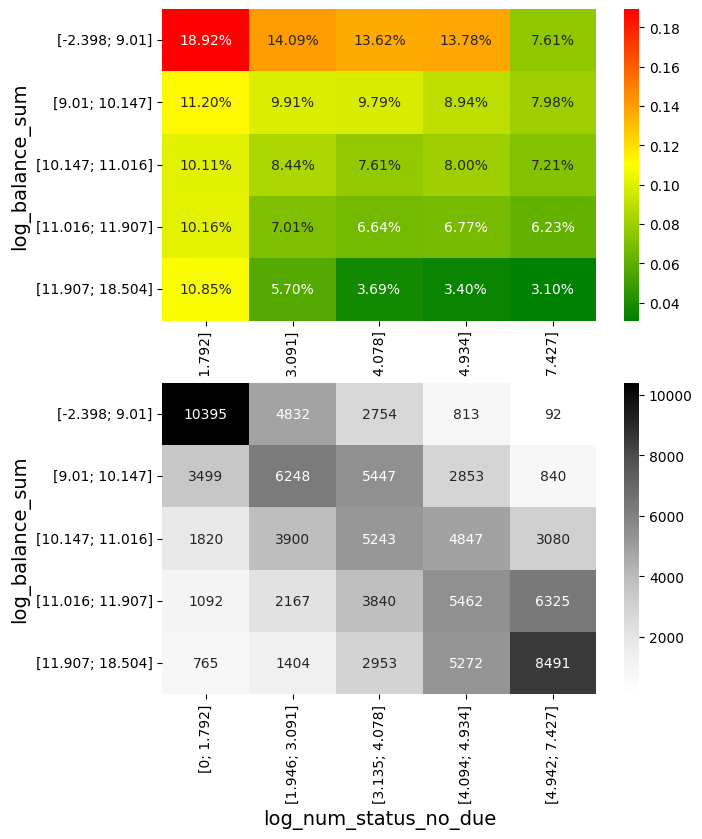

In [23]:
crosstab(
    bad=df.loc[df.sample_part == 'Train']['d4p12'],
    var_1=df.loc[df.sample_part == 'Train']['log_balance_sum'],
    var_2=df.loc[df.sample_part == 'Train']['log_num_status_no_due'],
    target='d4p12',
    name_1='log_balance_sum',
    name_2='log_num_status_no_due',
    nbuck_1=5,
    nbuck_2=5, # Каждый из признаков мы разбили на 5 бакетов. Определяем по количеству наблюдений в бакетах.
    null_buck_1=False,
    null_buck_2=False, # Уберем бакеты пропущенных значений, для этих признаков они совпадают.
    median=False
)

In [24]:
df['log_num_status_no_due'] = np.log(df['num_status_no_due'])
df['log_due_chance'] = np.log(df['due_chance'])

In [25]:
df.loc[df.sample_part == 'Train'][['log_num_status_no_due', 'log_due_chance']].corr().round(2)

,log_num_status_no_due,log_due_chance
log_num_status_no_due,1.00,-0.73
log_due_chance,-0.73,1.00


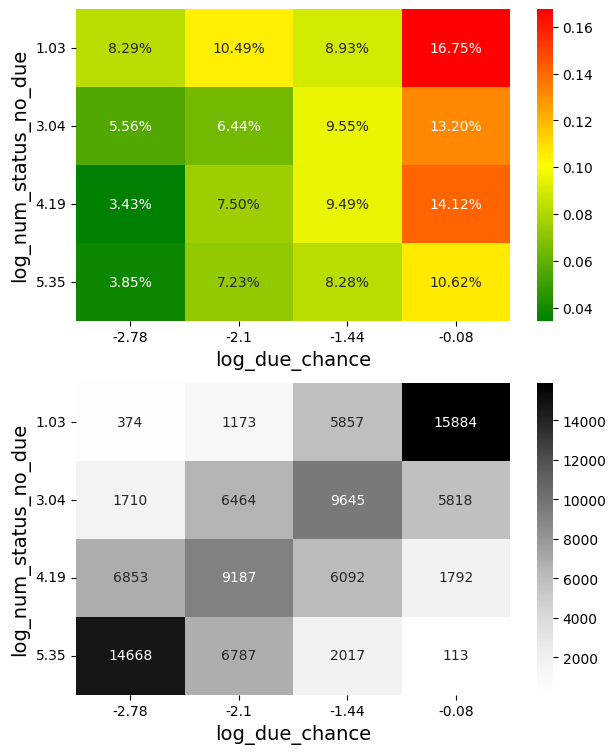

In [26]:
crosstab(
    bad=df.loc[df.sample_part == 'Train']['d4p12'],
    var_1=df.loc[df.sample_part == 'Train']['log_num_status_no_due'],
    var_2=df.loc[df.sample_part == 'Train']['log_due_chance'],
    target='d4p12',
    name_1='log_num_status_no_due',
    name_2='log_due_chance',
    nbuck_1=4,
    nbuck_2=4, # Каждый из признаков мы разбили на 4 бакета. Определяем по количеству наблюдений в бакетах.
    null_buck_1=False,
    null_buck_2=False, # Уберем бакеты пропущенных значений, для этих признаков они совпадают.
    median=True # Вместо границ бакетов рисуем медиану бакета
)

In [27]:
features_sem = [
    'bki_flg',
    'log1p_outstanding_rate',
    'log_num_status_no_due',
    'log_balance_sum',
    'log_due_chance',
    'marital_status_MAR',
    'marital_status_UNM',
    'marital_status_CIV',
    'marital_status_DIV',
    'age_younger_23',
    'female_flg',
    'telecom1_score',
    'telecom2_score',
    'bki_score',
    'partner1_score',
    'num_month_1.0',
    'num_month_2.0',
    'num_month_3.0',
    'num_month_4.0',
    'num_month_5.0',
    'num_month_6.0',
    'num_month_7.0',
    'num_month_8.0',
    'num_month_9.0',
    'num_month_10.0',
    'num_month_11.0',
    'num_month_12.0',

]

In [28]:
lr_filler = WoEFiller()

lr_filler.fit(
    X = df.loc[df.sample_part == 'Train'][features_sem],
    y = df.loc[df.sample_part == 'Train']['d4p12'],
    manual_values={'marital_status_MAR': 0,
                  'marital_status_UNM': 1,
                  'female_flg': 0},
    method='zero_woe'
)

df_transformed = lr_filler.transform(df)

In [29]:
# Для обучения модели используем библиотеку sklearn
from sklearn.linear_model import LogisticRegression

# Для приведения признаков к одному масштабу используем StandardScaler
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

In [30]:
lr_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='none', max_iter=500, solver='saga')
)

In [31]:
# обучение выполняется с помощью метода fit
# в нашем случае обучается два алгоритма: StandardScaler и LogisticRegression
# StandardScaler вычисляет среднее и стандартное отклонение признаков

lr_pipeline.fit(
    X=df_transformed.loc[df_transformed.sample_part == 'Train', features_sem],
    y=df_transformed.loc[df_transformed.sample_part == 'Train']['d4p12']
)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=500, penalty='none',
                                    solver='saga'))])

In [32]:
# метод predict_proba предсказывает вероятности принадлежности объекта к обоим классам
# нас интересует принадлежность к классу 1 - выход в дефолт 

df['init_model'] = lr_pipeline.predict_proba(df_transformed[features_sem])[:, 1]
df['init_model'].head()

0    0.174860
1    0.063261
2    0.022156
3    0.013685
4    0.027287
Name: init_model, dtype: float64

In [33]:
features_sem.remove('bki_flg')
features_sem.remove('marital_status_CIV')
features_sem.remove('marital_status_DIV')
features_sem.remove('age_younger_23')

print(f'Осталось признаков: {len(features_sem)}')

Осталось признаков: 23


In [34]:
features_sem_numeric = [
    'log1p_outstanding_rate',
    'log_num_status_no_due',
    'log_balance_sum',
    'log_due_chance',
    'telecom1_score',
    'telecom2_score',
    'bki_score'
]

In [35]:
# для трансформаций заведем копию исходного датафрейма

df_transformed = df.copy()

Удалено 21717 строк с нуллами, осталось 94434


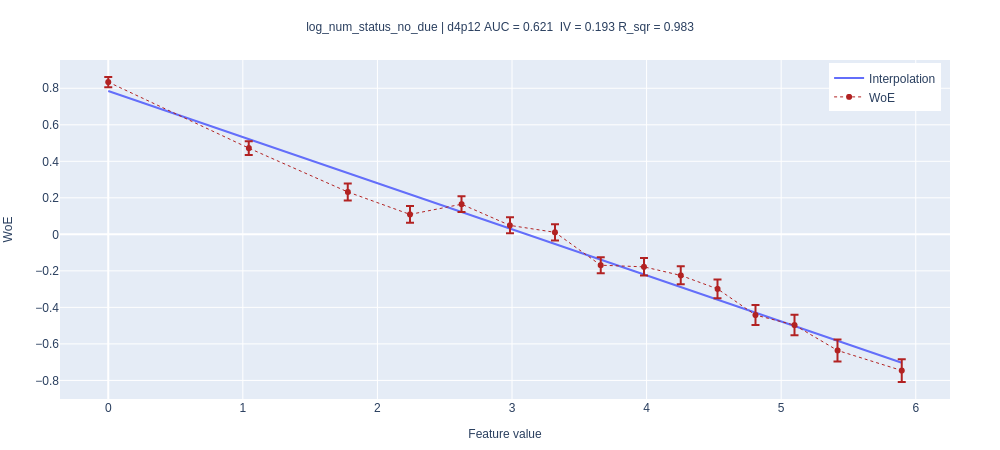

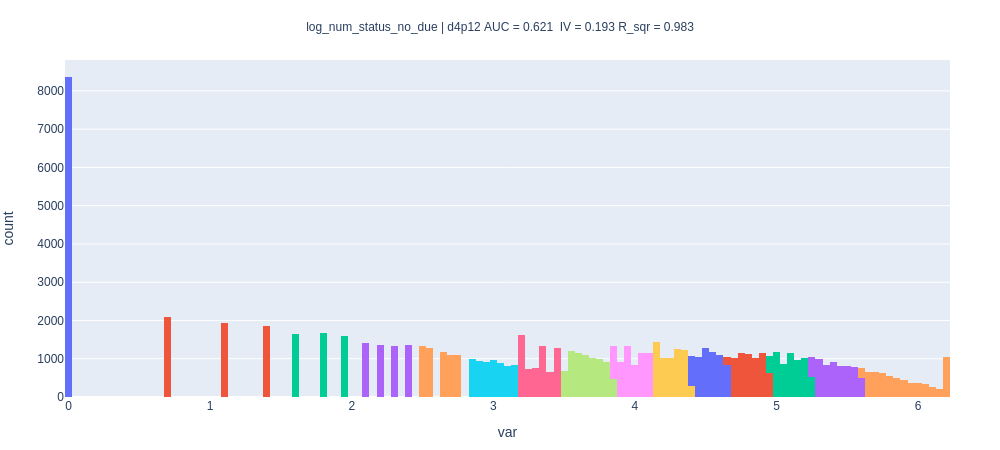

In [36]:
left_bound = None
right_bound = np.quantile(df.loc[df.sample_part == 'Train']['log_num_status_no_due'].dropna(), 0.99)

woe_line(
    var=np.clip(df.loc[df.sample_part == 'Train']['log_num_status_no_due'], left_bound, right_bound),
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm='log_num_status_no_due',
    target_nm='d4p12',
    plot_hist=True
)

df_transformed['log_num_status_no_due'] = np.clip(df_transformed['log_num_status_no_due'], left_bound, right_bound)

Удалено 21717 строк с нуллами, осталось 94434


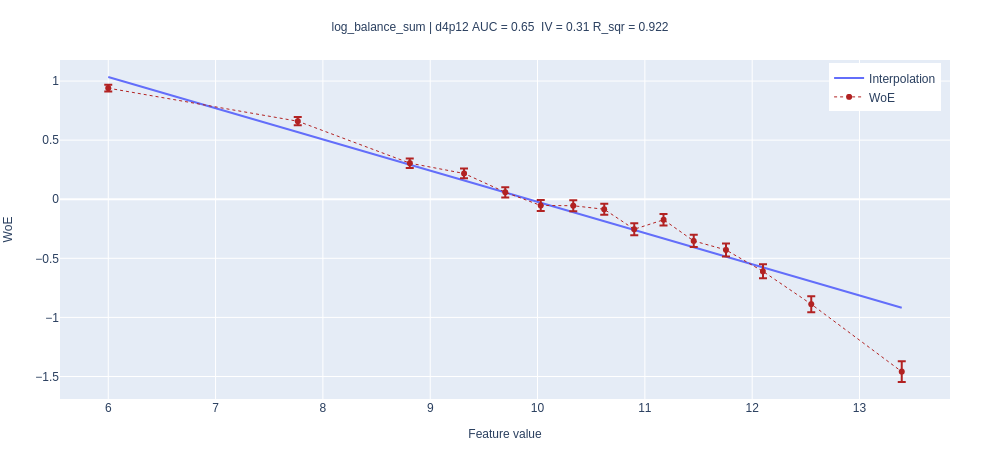

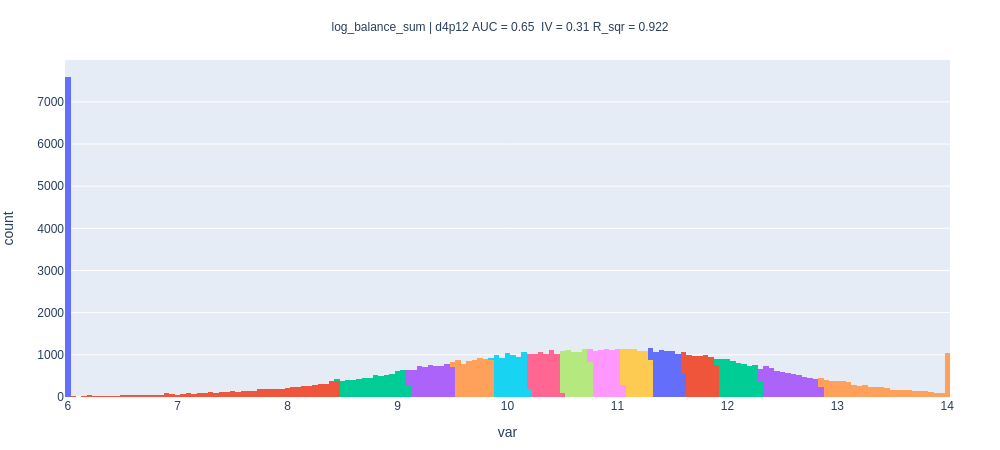

In [37]:
left_bound = 6
right_bound = 14

woe_line(
    var=np.clip(df.loc[df.sample_part == 'Train']['log_balance_sum'], left_bound, right_bound),
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm='log_balance_sum',
    target_nm='d4p12',
    plot_hist=True
)

df_transformed['log_balance_sum'] = np.clip(df_transformed['log_balance_sum'], left_bound, right_bound)

Удалено 21717 строк с нуллами, осталось 94434


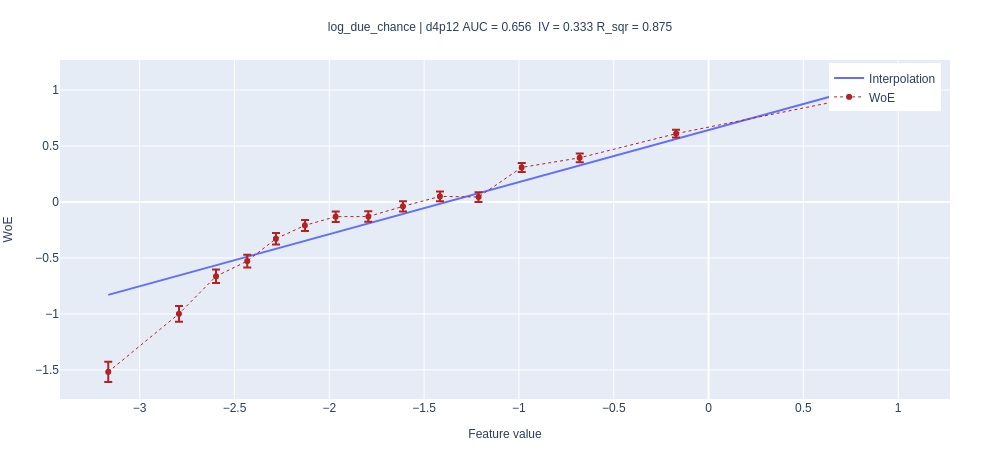

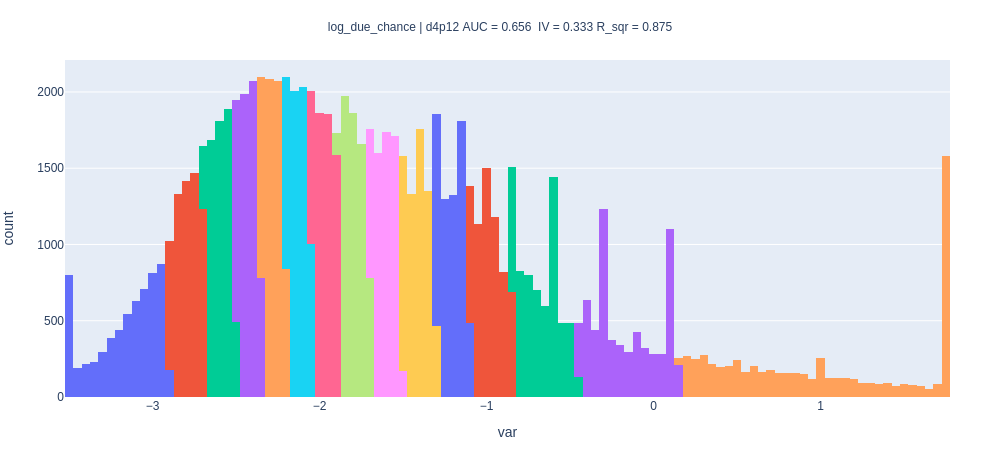

In [38]:
left_bound = -3.5
right_bound = 1.75

woe_line(
    var=np.clip(df.loc[df.sample_part == 'Train']['log_due_chance'], left_bound, right_bound),
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm='log_due_chance',
    target_nm='d4p12',
    plot_hist=True
)

df_transformed['log_due_chance'] = np.clip(df_transformed['log_due_chance'], left_bound, right_bound)

Удалено 94705 строк с нуллами, осталось 21446


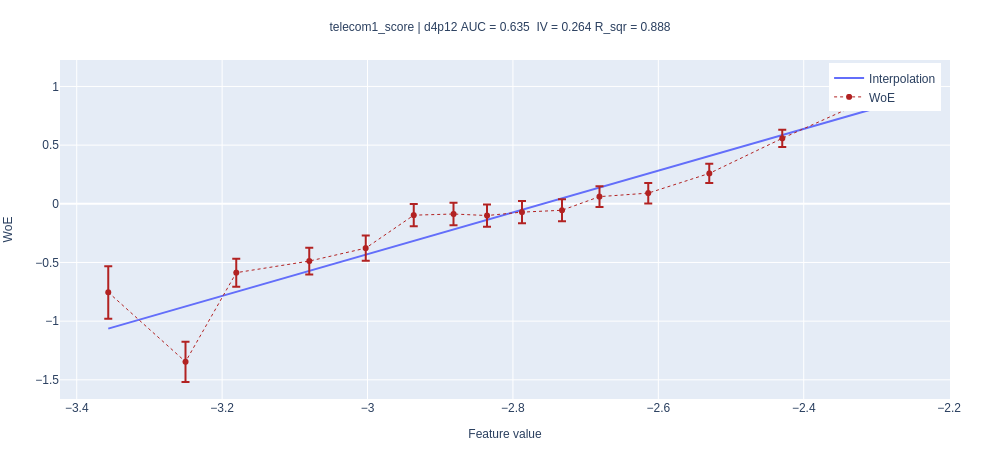

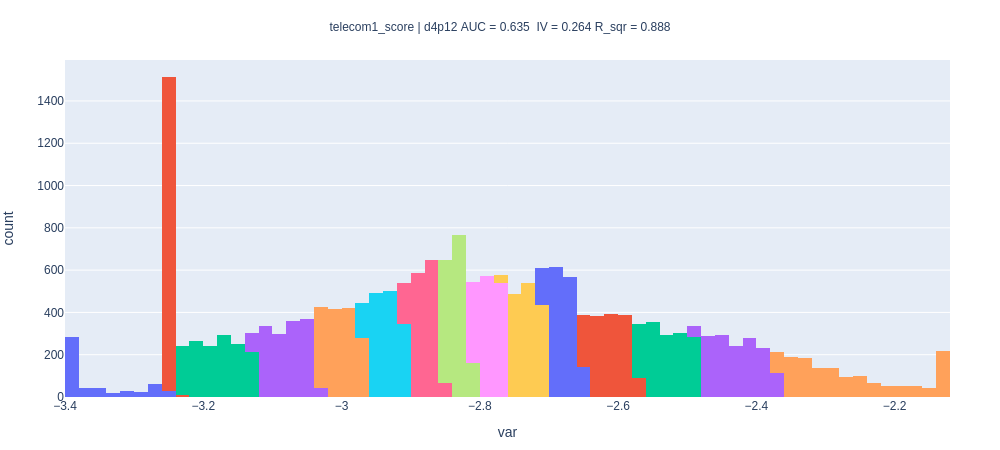

In [39]:
left_bound = -3.5
right_bound = np.quantile(df.loc[df.sample_part == 'Train']['telecom1_score'].dropna(), 0.99)

woe_line(
    var=np.clip(df.loc[df.sample_part == 'Train']['telecom1_score'], left_bound, right_bound),
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm='telecom1_score',
    target_nm='d4p12',
    plot_hist=True
)

df_transformed['telecom1_score'] = np.clip(df_transformed['telecom1_score'], left_bound, right_bound)

Удалено 23867 строк с нуллами, осталось 92284


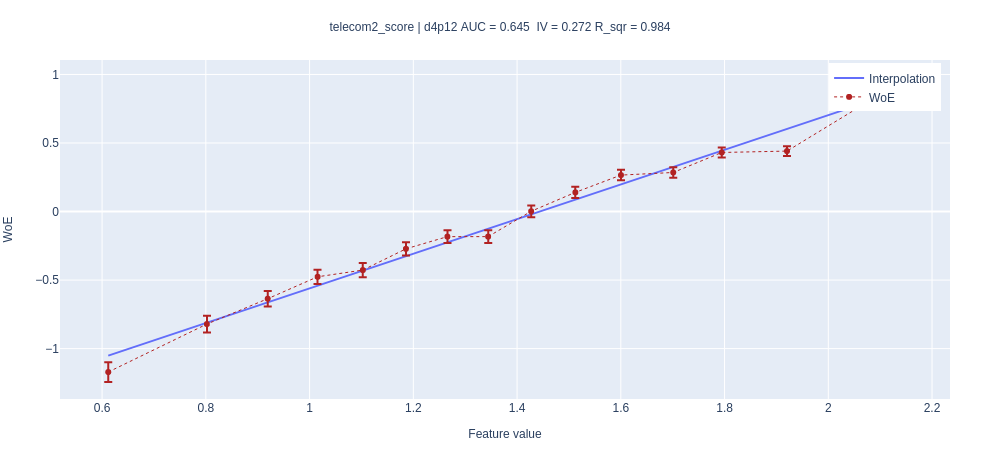

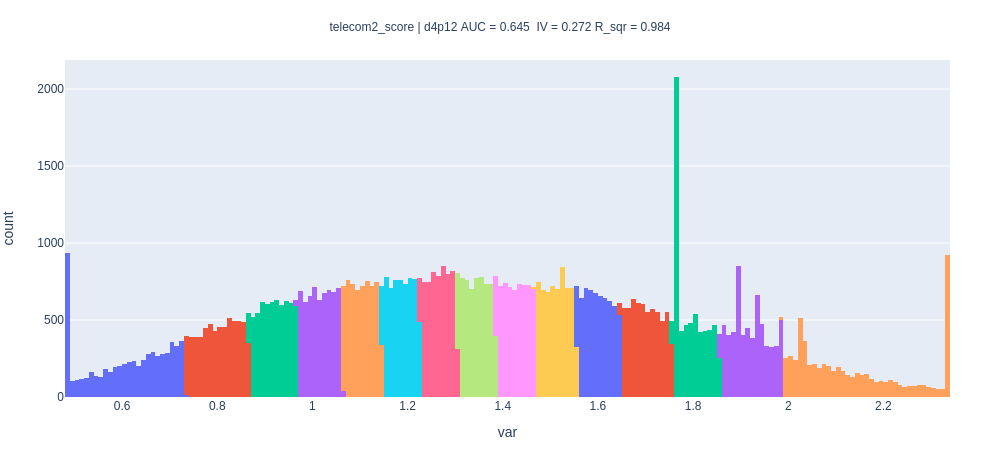

In [40]:
left_bound = np.quantile(df.loc[df.sample_part == 'Train']['telecom2_score'].dropna(), 0.01)
right_bound = np.quantile(df.loc[df.sample_part == 'Train']['telecom2_score'].dropna(), 0.99)

woe_line(
    var=np.clip(df.loc[df.sample_part == 'Train']['telecom2_score'], left_bound, right_bound),
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm='telecom2_score',
    target_nm='d4p12',
    plot_hist=True
)

df_transformed['telecom2_score'] = np.clip(df_transformed['telecom2_score'], left_bound, right_bound)

Удалено 2254 строк с нуллами, осталось 113897


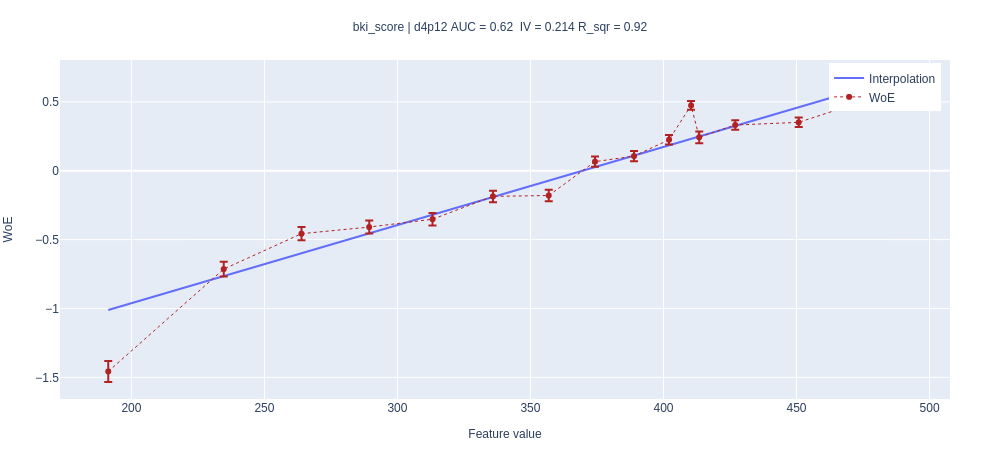

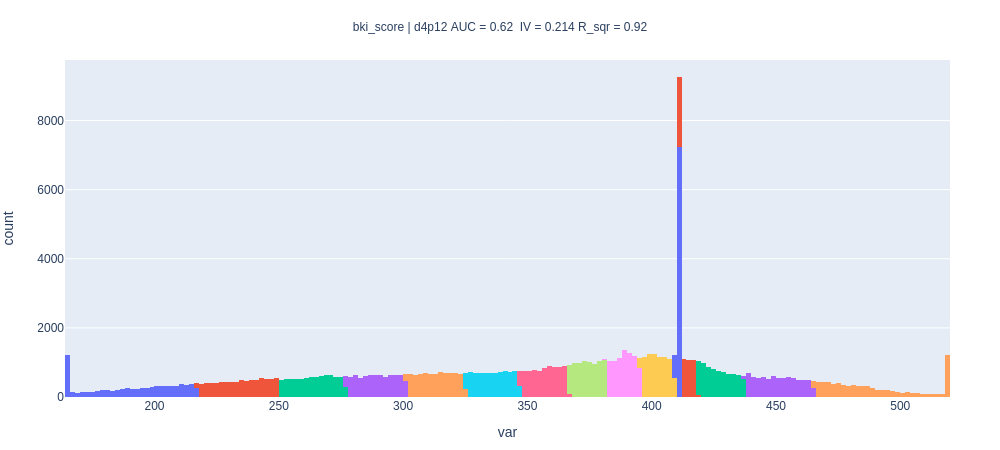

In [41]:
left_bound = np.quantile(df.loc[df.sample_part == 'Train']['bki_score'].dropna(), 0.01)
right_bound = np.quantile(df.loc[df.sample_part == 'Train']['bki_score'].dropna(), 0.99)

woe_line(
    var=np.clip(df.loc[df.sample_part == 'Train']['bki_score'], left_bound, right_bound),
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm='bki_score',
    target_nm='d4p12',
    plot_hist=True
)

df_transformed['bki_score'] = np.clip(df_transformed['bki_score'], left_bound, right_bound)

In [42]:
(df.groupby(['sample_part'])[features_sem].count().T / df.sample_part.value_counts()).round(2)

,Test,Train,Validation
log1p_outstanding_rate,0.66,0.64,0.67
log_num_status_no_due,0.83,0.81,0.83
log_balance_sum,0.83,0.81,0.83
log_due_chance,0.83,0.81,0.83
marital_status_MAR,1.00,1.00,1.00
marital_status_UNM,1.00,1.00,1.00
female_flg,1.00,1.00,1.00
telecom1_score,0.18,0.18,0.18
telecom2_score,0.80,0.79,0.81
bki_score,1.00,0.98,1.00


In [43]:
df_transformed['outstanding_rate_null_flg'] = df_transformed['outstanding_rate'].isna().astype(int)
df_transformed['telecom1_score_null_flg'] = df_transformed['telecom1_score'].isna().astype(int)
df_transformed['telecom2_score_null_flg'] = df_transformed['telecom2_score'].isna().astype(int)

In [44]:
features_sem.append('telecom2_score_null_flg')

In [45]:
lr_filler = WoEFiller()

lr_filler.fit(
    X = df_transformed.loc[df_transformed.sample_part == 'Train'][features_sem],
    y = df_transformed.loc[df_transformed.sample_part == 'Train']['d4p12'],
    manual_values={'marital_status_MAR': 0,
                  'marital_status_UNM': 1,
                  'female_flg': 0,
                  'telecom2_score_null_flg': 0},
    method='zero_woe'
)

{'log1p_outstanding_rate': 0.5745007597810593,
 'log_num_status_no_due': 3.110262919588663,
 'log_balance_sum': 9.91680951795708,
 'log_due_chance': -1.3822540417613105,
 'marital_status_MAR': 0,
 'marital_status_UNM': 1,
 'female_flg': 0,
 'telecom1_score': -2.7586655024034434,
 'telecom2_score': 1.443454159860927,
 'bki_score': 369.56015711559877,
 'partner1_score': -3.275586456402541,
 'num_month_1.0': 0.13406680998579695,
 'num_month_2.0': 0.14751075313937412,
 'num_month_3.0': 0.1511941276878458,
 'num_month_4.0': 0.10215933622090824,
 'num_month_5.0': 0.021729529305803463,
 'num_month_6.0': 0.03381913708886271,
 'num_month_7.0': 0.052858031765385935,
 'num_month_8.0': 0.06185686542297871,
 'num_month_9.0': 0.060637708709303156,
 'num_month_10.0': 0.06719081667981491,
 'num_month_11.0': 0.07247927853153492,
 'num_month_12.0': 0.08997481429952205,
 'telecom2_score_null_flg': 0}

In [46]:
df_transformed = lr_filler.transform(df_transformed)

In [47]:
df_transformed.head()

,application_rk,crm_income_dt,request_amt,bki_flg,no_due_and_short_history_flg,outstanding_rate,num_active_credits,num_status_no_due,balance_sum,due_chance,...,init_model,outstanding_rate_null_flg,telecom1_score_null_flg,telecom2_score_null_flg,log1p_outstanding_rate_null_flg,log_num_status_no_due_null_flg,log_balance_sum_null_flg,log_due_chance_null_flg,bki_score_null_flg,partner1_score_null_flg
0,0,2018-06-22,NaN,1,0.0,0.884391,1.0,31.0,21310.666667,0.325297,...,0.174860,0,0,0,0,0,0,0,0,0
1,1,2019-11-21,NaN,1,0.0,0.997177,1.0,1.0,47579.692308,0.377232,...,0.063261,0,1,0,0,0,0,0,0,0
2,2,2018-03-05,100000.0,1,0.0,NaN,0.0,58.0,76023.428571,0.091311,...,0.022156,1,1,0,1,0,0,0,0,0
3,3,2018-08-08,NaN,1,0.0,0.469932,2.0,231.0,151928.000000,0.034171,...,0.013685,0,1,0,0,0,0,0,0,0
4,4,2019-01-04,NaN,1,0.0,0.129258,1.0,219.0,223517.000000,0.040406,...,0.027287,0,1,1,0,0,0,0,0,0


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

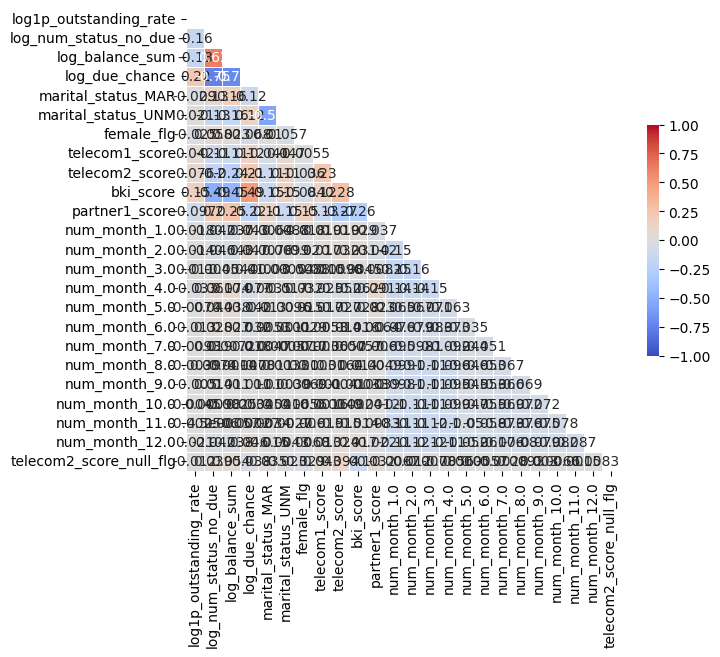

In [49]:
corr = df_transformed.loc[df_transformed.sample_part == 'Train', features_sem].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [50]:
features_sem.remove('log_num_status_no_due')

In [51]:

# обучение выполняется с помощью метода fit
# в нашем случае обучается два алгоритма: StandardScaler и LogisticRegression
# StandardScaler вычисляет среднее и стандартное отклонение признаков

lr_pipeline.fit(
    X=df_transformed.loc[df_transformed.sample_part == 'Train', features_sem],
    y=df_transformed.loc[df_transformed.sample_part == 'Train']['d4p12']
)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=500, penalty='none',
                                    solver='saga'))])

In [52]:
# метод predict_proba предсказывает вероятности принадлежности объекта к обоим классам
# нас интересует принадлежность к классу 1 - выход в дефолт 

df['pd_model'] = lr_pipeline.predict_proba(df_transformed[features_sem])[:, 1]
df['pd_model'].head()

0    0.195412
1    0.068743
2    0.024008
3    0.014387
4    0.022229
Name: pd_model, dtype: float64

In [53]:
feature_coef = pd.DataFrame({
    'feature': features_sem,
    'coef': lr_pipeline[1].coef_[0],
    'mean': lr_pipeline[0].mean_,
    'std': lr_pipeline[0].scale_
}).sort_values(by='coef', key=abs, ascending=False)

feature_coef.round(3)

,feature,coef,mean,std
7,telecom2_score,0.294,1.374,0.375
9,partner1_score,-0.278,-3.216,0.317
2,log_due_chance,0.173,-1.572,0.970
8,bki_score,0.148,355.506,80.525
0,log1p_outstanding_rate,0.135,0.559,0.162
1,log_balance_sum,-0.134,10.254,1.736
3,marital_status_MAR,-0.096,0.360,0.480
6,telecom1_score,0.078,-2.769,0.124
14,num_month_5.0,-0.077,0.029,0.168
11,num_month_2.0,0.076,0.131,0.337


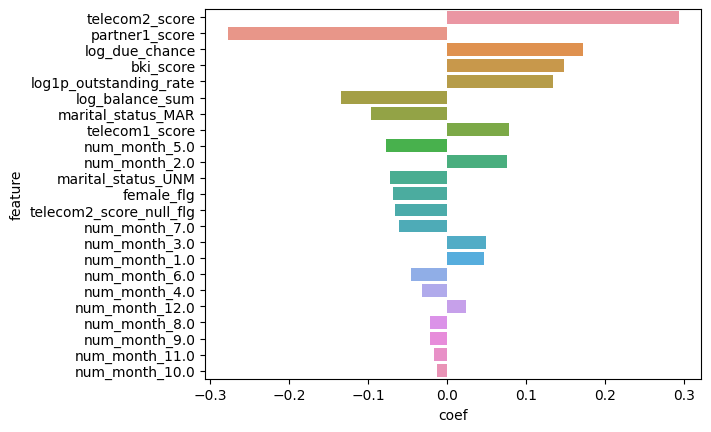

In [54]:
sns.barplot(data=feature_coef, x='coef', y='feature', orient='h')
plt.show()

In [55]:
from scipy.special import logit

In [56]:
# применим функцию logit к предсказанным вероятностям

df['logit_model'] = logit(df['pd_model'])
df['logit_model']

0        -1.415221
1        -2.606158
2        -3.705055
3        -4.226915
4        -3.783877
            ...   
194361   -3.350695
194362   -2.125231
194363   -2.516065
194364   -2.214768
194365   -3.159817
Name: logit_model, Length: 194366, dtype: float64

In [57]:
from sklearn.metrics import roc_auc_score

In [58]:
auc_dic = {
    'L1': {},
    'L2': {}
}

In [59]:
lr_l1_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l1', max_iter=500, solver='saga')
)

lr_l2_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l2', max_iter=500, solver='saga')
)

In [60]:
for C in np.logspace(-3, 2, 20):
    lr_l1_pipeline[1].C = C
    lr_l2_pipeline[1].C = C
    
    lr_l1_pipeline.fit(
        X=df_transformed.loc[df_transformed.sample_part == 'Train', features_sem],
        y=df_transformed.loc[df_transformed.sample_part == 'Train']['d4p12']
    )
    
    lr_l2_pipeline.fit(
        X=df_transformed.loc[df_transformed.sample_part == 'Train', features_sem],
        y=df_transformed.loc[df_transformed.sample_part == 'Train']['d4p12']
    )
    
    auc_l1 = roc_auc_score(
        df_transformed.loc[df_transformed.sample_part == 'Validation']['d4p12'],
        lr_l1_pipeline.predict_proba(df_transformed.loc[df_transformed.sample_part == 'Validation', features_sem])[:, 1]
    )
    
    
    auc_l2 = roc_auc_score(
        df_transformed.loc[df_transformed.sample_part == 'Validation']['d4p12'],
        lr_l2_pipeline.predict_proba(df_transformed.loc[df_transformed.sample_part == 'Validation', features_sem])[:, 1]
    )
    
    auc_dic['L1'][C] = auc_l1
    auc_dic['L2'][C] = auc_l2

In [61]:
l1_best_C = max(auc_dic['L1'], key=auc_dic['L1'].get)
l2_best_C = max(auc_dic['L2'], key=auc_dic['L2'].get)

print(f'L1: {round(l1_best_C, 3)}, L2: {round(l2_best_C, 3)}')

L1: 0.038, L2: 0.001


In [62]:
lr_l1_pipeline[1].C = l1_best_C
lr_l2_pipeline[1].C = l2_best_C

lr_l1_pipeline.fit(
    X=df_transformed.loc[df_transformed.sample_part == 'Train', features_sem],
    y=df_transformed.loc[df_transformed.sample_part == 'Train']['d4p12']
)

lr_l2_pipeline.fit(
    X=df_transformed.loc[df_transformed.sample_part == 'Train', features_sem],
    y=df_transformed.loc[df_transformed.sample_part == 'Train']['d4p12']
)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.001, max_iter=500, solver='saga'))])

In [63]:
df['pd_model_l1'] = lr_l1_pipeline.predict_proba(df_transformed[features_sem])[:, 1]
df['pd_model_l2'] = lr_l2_pipeline.predict_proba(df_transformed[features_sem])[:, 1]

df[['pd_model', 'pd_model_l1', 'pd_model_l2']]

,pd_model,pd_model_l1,pd_model_l2
0,0.195412,0.197518,0.191568
1,0.068743,0.068475,0.070223
2,0.024008,0.024085,0.026626
3,0.014387,0.014700,0.016289
4,0.022229,0.022595,0.024475
...,...,...,...
194361,0.033872,0.033688,0.035822
194362,0.106669,0.108340,0.107611
194363,0.074740,0.076071,0.076111
194364,0.098432,0.100169,0.100673


In [64]:
# функция отрисовывает метрику (нам интересен ROC AUC) для нескольких скоров во времени

from model_tools import plot_metric_time

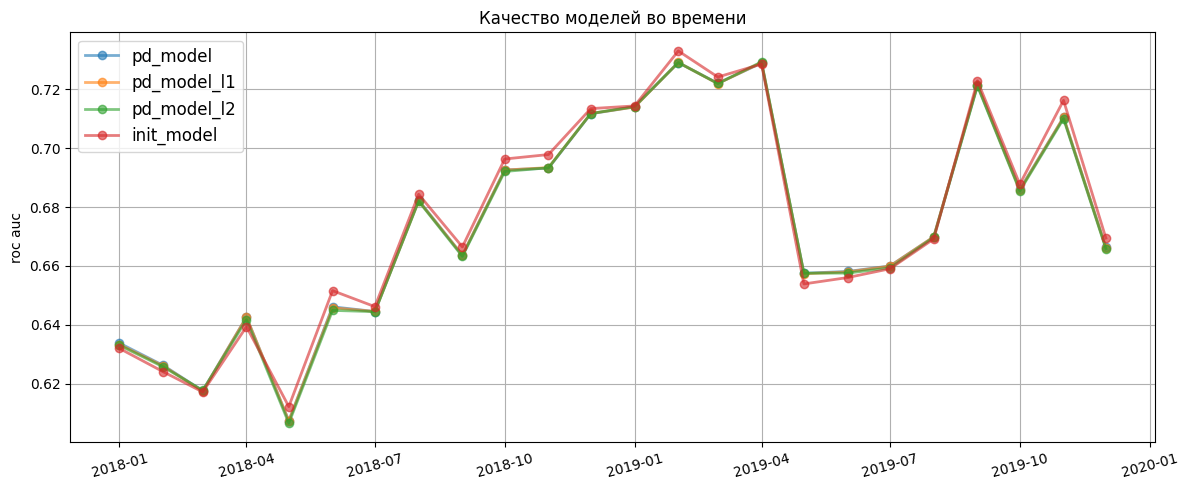

,pd_model,pd_model_l1,pd_model_l2,init_model
2018-01-01,0.633833,0.633354,0.633086,0.632025
2018-02-01,0.626270,0.626083,0.625774,0.624110
2018-03-01,0.617633,0.617531,0.617792,0.617259
2018-04-01,0.642656,0.642667,0.641765,0.639398
2018-05-01,0.607459,0.607470,0.606663,0.612291
2018-06-01,0.646148,0.645820,0.644939,0.651632
2018-07-01,0.644556,0.644565,0.644499,0.646203
2018-08-01,0.682304,0.682128,0.681967,0.684317
2018-09-01,0.663626,0.663669,0.663259,0.666468
2018-10-01,0.692595,0.692549,0.692065,0.696298


In [65]:
plot_metric_time(
    df=df,
    features=['pd_model', 'pd_model_l1', 'pd_model_l2', 'init_model'],
    target='d4p12',
    time='month_dt',
    ttl='Качество моделей во времени'
)

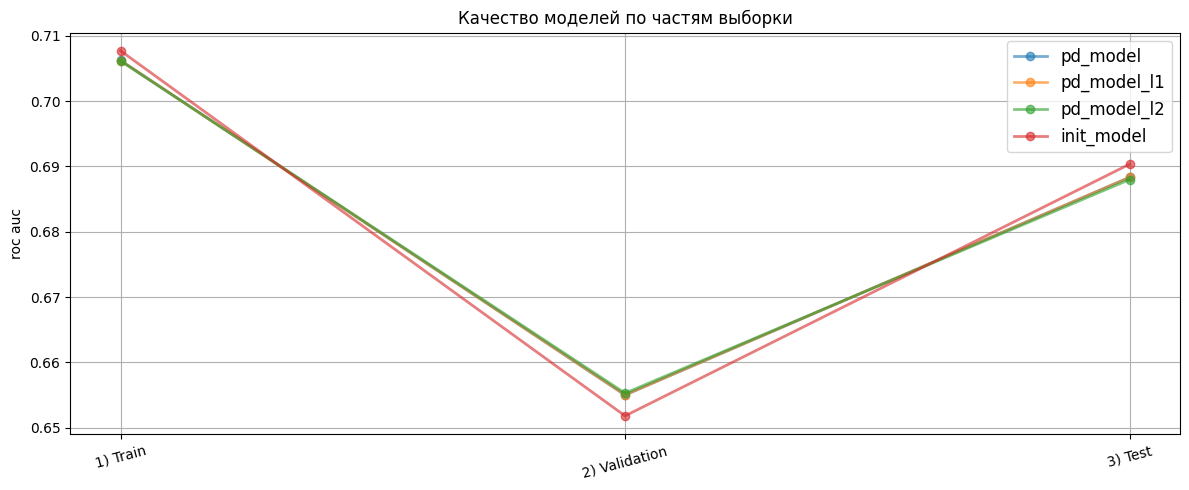

,pd_model,pd_model_l1,pd_model_l2,init_model
1) Train,0.706,0.706,0.706,0.708
2) Validation,0.655,0.655,0.655,0.652
3) Test,0.688,0.688,0.688,0.690


In [66]:
# Для правильного упорядочивания частей выборки
df['sample_part_num'] = df['sample_part']
df.loc[df.sample_part == 'Train', 'sample_part_num'] = '1) Train'
df.loc[df.sample_part == 'Validation', 'sample_part_num'] = '2) Validation'
df.loc[df.sample_part == 'Test', 'sample_part_num'] = '3) Test'


plot_metric_time(
    df=df,
    features=['pd_model', 'pd_model_l1', 'pd_model_l2', 'init_model'],
    target='d4p12',
    time='sample_part_num',
    ttl='Качество моделей по частям выборки'
).round(3)